# Лаборатораня работа №5: Ансамбли моделей машинного обучения.

In [3]:
#Датасет содержит данные о кредитах на покупку электроники, которые были одобрены Tinkoff.ru. 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error
from sklearn.neural_network import MLPClassifier
from warnings import simplefilter

simplefilter('ignore')

In [4]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('credit_train_preprocess.csv', encoding='cp1251', sep=',')

In [5]:
# смотрим на первые пять строк
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 39 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   age                   170746 non-null  float64
 1   credit_sum            170746 non-null  float64
 2   credit_month          170746 non-null  int64  
 3   tariff_id             170746 non-null  float64
 4   score_shk             170746 non-null  float64
 5   monthly_income        170746 non-null  float64
 6   credit_count          170746 non-null  float64
 7   overdue_credit_count  170746 non-null  float64
 8   open_account_flg      170746 non-null  int64  
 9   gender_F              170746 non-null  int64  
 10  gender_M              170746 non-null  int64  
 11  job_position_ATP      170746 non-null  int64  
 12  job_position_BIS      170746 non-null  int64  
 13  job_position_BIU      170746 non-null  int64  
 14  job_position_DIR      170746 non-null  int64  
 15  

## 1) Корреляционный анализ

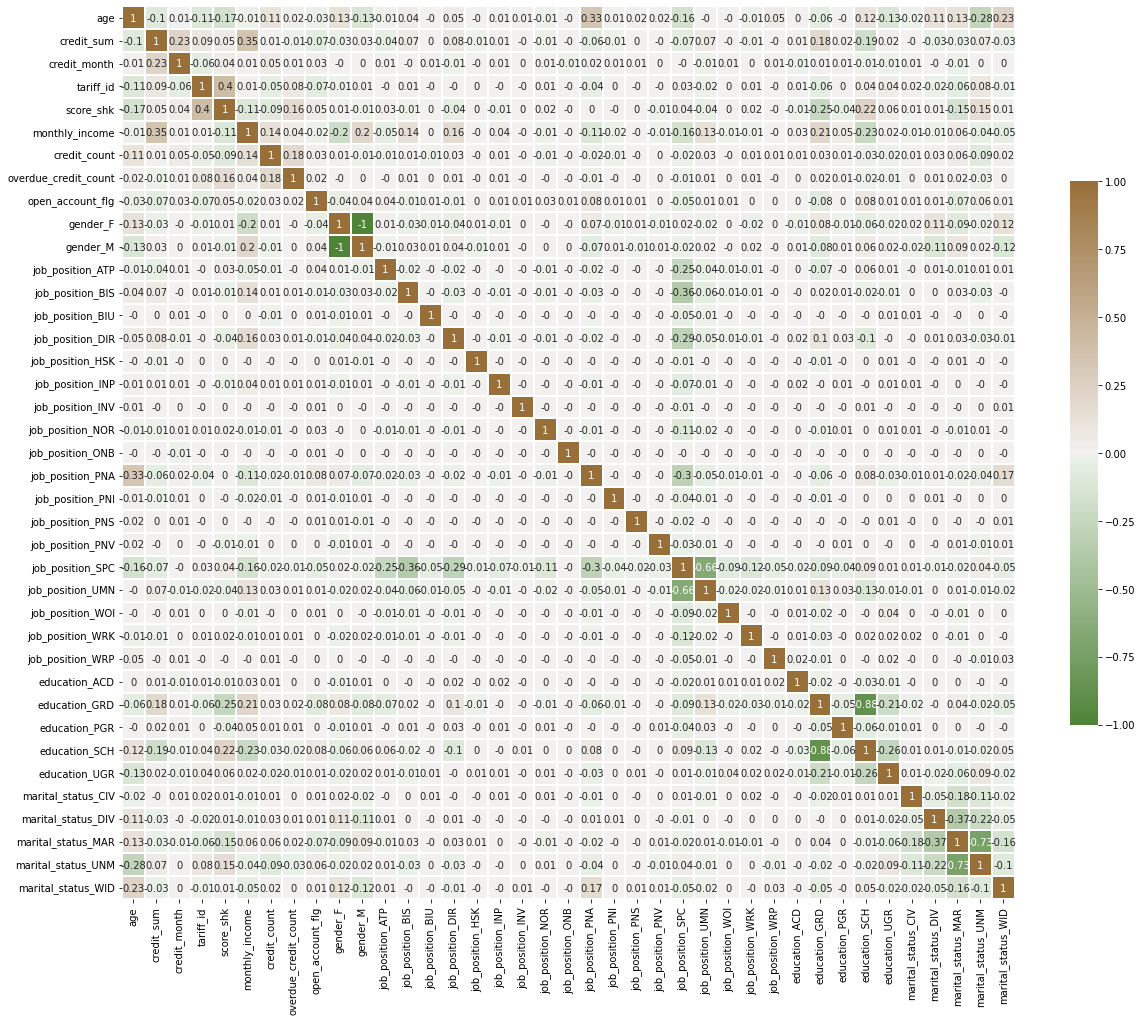

In [7]:
corr = data.corr().round(2)
f, ax = plt.subplots(figsize=(20, 20)) 
cmap = sns.diverging_palette(120, 50, as_cmap=True) 
sns.heatmap(data=corr, cmap=cmap, annot=True, vmax=1.0, square=True, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax)#, vmax=1.0, square=True, xticklabels=2, yticklabels=2, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax) 
plt.show()

In [8]:
print('Признаки, имеющие максимальную по модулю корреляцию с целевым признаком')
best_params = data.corr()['open_account_flg'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.02]
best_params

Признаки, имеющие максимальную по модулю корреляцию с целевым признаком


education_GRD         0.082371
education_SCH         0.078337
job_position_PNA      0.076889
credit_sum            0.072039
tariff_id             0.067346
marital_status_MAR    0.067112
marital_status_UNM    0.061312
job_position_SPC      0.049143
score_shk             0.048686
gender_F              0.044265
gender_M              0.044265
job_position_ATP      0.038288
credit_count          0.032374
age                   0.031062
job_position_NOR      0.027320
credit_month          0.025809
monthly_income        0.023697
Name: open_account_flg, dtype: float64

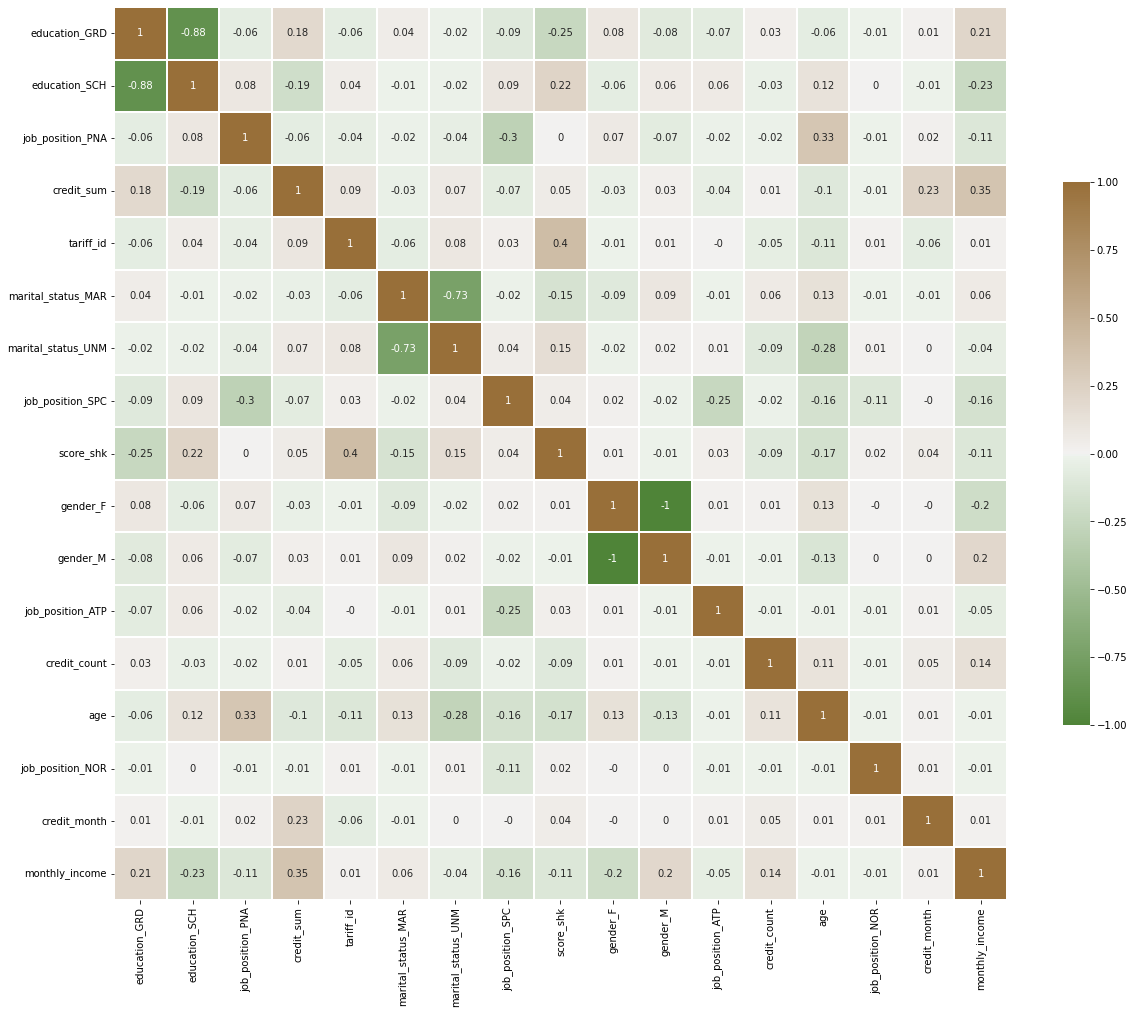

In [9]:
corr = data[best_params.index].corr().round(2)
f, ax = plt.subplots(figsize=(20, 20)) 
cmap = sns.diverging_palette(120, 50, as_cmap=True) 
sns.heatmap(data=corr, cmap=cmap, annot=True, vmax=1.0, square=True, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax)#, vmax=1.0, square=True, xticklabels=2, yticklabels=2, linewidths=.3, cbar_kws={"shrink": .5}, ax=ax) 
plt.show()

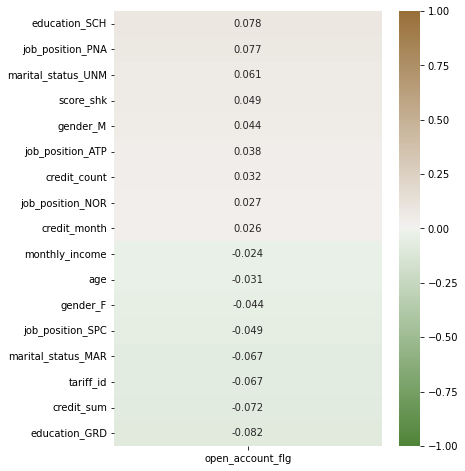

In [10]:
plt.figure(figsize=(6, 8))
sns.heatmap(pd.DataFrame(data[np.append(best_params.index.values, 'open_account_flg')].corr()['open_account_flg'].sort_values(ascending=False)[1:]), vmin=-1, vmax=1, cmap=cmap, annot=True)
plt.show()

## 2) Разделение выборки на обучающую и тестовую

In [11]:
data_best = data[best_params.index]
data_best.head()

,education_GRD,education_SCH,job_position_PNA,credit_sum,tariff_id,marital_status_MAR,marital_status_UNM,job_position_SPC,score_shk,gender_F,gender_M,job_position_ATP,credit_count,age,job_position_NOR,credit_month,monthly_income
0,1,0,0,59998.00,1.6,1,0,0,0.461599,0,1,0,1.0,34.0,0,10,30000.0
1,0,1,0,10889.00,1.1,1,0,0,0.461599,1,0,0,2.0,34.0,0,6,35000.0
2,0,1,0,10728.00,1.1,1,0,1,0.461599,0,1,0,5.0,32.0,0,12,35000.0
3,0,1,0,12009.09,1.1,1,0,1,0.461599,1,0,0,2.0,27.0,0,12,35000.0
4,0,1,0,21229.00,1.1,1,0,1,0.421385,0,1,0,1.0,45.0,0,10,35000.0


In [12]:
y = data['open_account_flg']
#X = data.drop('open_account_flg', axis=1)
X = data_best
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=21)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=21)

## 3) Масштабирование данных

In [13]:
scaler = MinMaxScaler().fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train.describe()

,education_GRD,education_SCH,job_position_PNA,credit_sum,tariff_id,marital_status_MAR,marital_status_UNM,job_position_SPC,score_shk,gender_F,gender_M,job_position_ATP,credit_count,age,job_position_NOR,credit_month,monthly_income
count,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000,29880.000000
mean,0.425000,0.514759,0.023561,0.117340,0.345539,0.549665,0.304518,0.787651,0.404031,0.521452,0.478548,0.015663,0.117555,0.348769,0.003648,0.242378,0.062588
std,0.494351,0.499790,0.151679,0.082275,0.252486,0.497536,0.460211,0.408978,0.129396,0.499548,0.499548,0.124169,0.096737,0.198402,0.060289,0.108435,0.044938
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.060249,0.106383,0.000000,0.000000,1.000000,0.310565,0.000000,0.000000,0.000000,0.055556,0.188679,0.000000,0.212121,0.034926
50%,0.000000,1.000000,0.000000,0.092536,0.340426,1.000000,0.000000,1.000000,0.396125,1.000000,0.000000,0.000000,0.111111,0.301887,0.000000,0.212121,0.053309
75%,1.000000,1.000000,0.000000,0.148270,0.638298,1.000000,1.000000,1.000000,0.490279,1.000000,1.000000,0.000000,0.166667,0.471698,0.000000,0.272727,0.080882
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4)  Модель №1: Случайный лес

In [82]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score

def print_metrics(y_test, y_pred):
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"F1-measure: {f1_score(y_test, y_pred)}")
    print('mean_absolute_error: {}'.format(round(mean_absolute_error(y_test, y_pred), 2)))
    print('median_absolute_error: {}'.format(round(median_absolute_error(y_test, y_pred), 2)))
    print('r2_score: {}'.format(round(r2_score(y_test, y_pred), 2)))

In [15]:
print_metrics(y_test, RandomForestClassifier(random_state=17).fit(x_train, y_train).predict(x_test))

Precision: 0.4737991266375546
F1-measure: 0.15617128463476068


## Подбор гиперпараметров

In [90]:
rf = RandomForestClassifier(random_state=17)
params = {'n_estimators': [100, 1000], 
          'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 3, 5]}
grid_cv = GridSearchCV(estimator=rf, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 1000}


In [ ]:
best_rf = grid_cv.best_estimator_
best_rf.fit(x_train, y_train)
y_pred_rf = best_rf.predict(x_test)
print_metrics(y_test, y_pred_rf)

## 5) Модель №2: Градиентный бустинг

In [16]:
print_metrics(y_test, GradientBoostingClassifier(random_state=17).fit(x_train, y_train).predict(x_test))

Accuracy: 0.8218803685772295
Precision: 0.5819672131147541
Recall: 0.06118052563550194
F1-measure: 0.11072124756335285


## Подбор гиперпараметров

In [76]:
gb = GradientBoostingClassifier(random_state=17)
params = {'n_estimators': [10, 50, 100, 200], 'min_samples_leaf': [1, 3, 5]}
grid_cv = GridSearchCV(estimator=gb, cv=5, param_grid=params, n_jobs=-1, scoring='f1')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'min_samples_leaf': 5, 'n_estimators': 200}


In [77]:
best_gb = grid_cv.best_estimator_
best_gb.fit(x_train, y_train)
y_pred_gb = best_gb.predict(x_test)
print_metrics(y_test, y_pred_gb)

Precision: 0.5709876543209876
F1-measure: 0.13988657844990549


## 6) Модель №3: Стекинг

In [24]:
dataset = Dataset(x_train, y_train, x_test)

In [97]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

layer_one_estimators = [
                        ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                        ('rf_3', GradientBoostingClassifier(n_estimators=200)),
                       ]
layer_two_estimators = [
                        ('dt_2', DecisionTreeClassifier()),
                        ('rf_2', RandomForestClassifier(n_estimators=10, random_state=42)),
                        ('rf_4', GradientBoostingClassifier(n_estimators=20))
                       ]

layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=MLPClassifier(random_state=1488))
# Create Final model by 
clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)


#layer_2 = StackingClassifier(estimators=profi_learners, final_estimator=LogisticRegression())
#layer_1 = StackingClassifier(estimators=base_learners, final_estimator=layer_2)

clf.fit(x_train, y_train)

StackingClassifier(estimators=[('rf_1',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('rf_3',
                                GradientBoostingClassifier(n_estimators=200))],
                   final_estimator=StackingClassifier(estimators=[('dt_2',
                                                                   DecisionTreeClassifier()),
                                                                  ('rf_2',
                                                                   RandomForestClassifier(n_estimators=10,
                                                                                          random_state=42)),
                                                                  ('rf_4',
                                                                   GradientBoostingClassifier(n_estimators=20))],
                                             

In [98]:
print_metrics(y_test, clf.predict(x_test))

Precision: 0.6148148148148148
F1-measure: 0.12813585488228482
mean_absolute_error: 0.18
median_absolute_error: 0.0
r2_score: -0.19


## Сравнение моделей

In [6]:
print("Случайный лес")
print_metrics(y_test, y_pred_rf)

print("\nГрадиентный бустинг")
print_metrics(y_test, y_pred_gb)

print("\nСтекинг")
print_metrics(y_test, y_pred_stack)

Случайный лес


NameError: name 'print_metrics' is not defined